<a href="https://colab.research.google.com/github/Kitiksha1000/Case-Study-12--Ensuring-QA-Measures-in-Credit-Risk-Assessment/blob/main/General_Preprocessing_pipeline__Case_Study_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 12.2 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
df=pd.read_csv('/content/PAKDD_Modelling_data.csv')
df.shape

/tmp/ipython-input-2-2011989236.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/PAKDD_Modelling_data.csv')


(50000, 54)

In [ ]:

df.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


## Creating config for each dataset

In [ ]:
config_pakdd = {
    "dataset_name": "PAKDD2010_Modelling_Data",

    # Columns
    "id_column": "ID_CLIENT",
    "target_column": "TARGET_LABEL_BAD",

    # Feature lists
    "numerical_features": [
        "AGE", "INCOME", "QUANT_CARS", "QUANT_BANKING_ACCOUNTS",
        "LOAN_AMOUNT", "QUANT_DEPENDANTS", "EXPENSES"
    ],
    "categorical_features": [
        "GENDER", "MARITAL_STATUS", "EDUCATION", "OCCUPATION"
    ],

    # Preprocessing strategies
    "num_impute_strategy": "median",
    "cat_impute_strategy": "most_frequent",

    # Optional drops
    "drop_high_missing": { "enabled": True, "threshold": 0.4 },
    "drop_single_unique": True,
    "drop_id_column": True,
    "drop_dominant_columns": { "enabled": True, "threshold": 0.99 },
    "drop_high_correlation": { "enabled": True, "threshold": 0.8 },
    "drop_high_cramersv": { "enabled": True, "threshold": 1.0 },

    # Outlier handling
    "cap_outliers": {
        "enabled": True,
        "strategy": "cap",       # or "median"
        "upper_percentile": 0.99,
        "lower_percentile": 0.01
    },

    # Encoding
    "encoding": {
        "low_cardinality_strategy": "onehot",         # "onehot", "ordinal"
        "high_cardinality_strategy": "target",        # "target", "hash", "leave_one_out"
        "high_cardinality_threshold": 10
    },

    # Scaling
    "scaling": {
        "strategy": "standard",   # "minmax", "robust", "none"
        "columns": []             # empty = scale all numeric
    },

    # Train-test split
    "split": {
        "test_size": 0.2,
        "random_state": 42,
        "stratify": True
    },

    # Feature selection
    "feature_selection": {
        "method": "model_top_n",            # "variance", "mutual_info", "model_top_n", "rfe", "rfecv", "none"
        "top_n": 40,
        "threshold": 0.01,
        "model_type": "XGB",
        "scoring": "roc_auc"
    },

    # Model & hyperparameters
    "task": "classification",  # or "regression"
    "model": {
        "type": "XGB"          # "RandomForest", "XGB", "LogisticRegression", "LinearRegression"
    },
    "hyperparameters": {
        "RandomForest": {
            "n_estimators": 150,
            "max_depth": 8,
            "class_weight": "balanced",
            "random_state": 42
        },
        "XGB": {
            "n_estimators": 100,
            "max_depth": 6,
            "learning_rate": 0.1,
            "random_state": 42,
            "use_label_encoder": False,
            "eval_metric": "logloss"
        },
        "LogisticRegression": {
            "max_iter": 1000,
            "class_weight": "balanced",
            "random_state": 42
        },
        "LinearRegression": {}
    },

    # Cross-validation
    "cross_validation": {
        "enabled": True,
        "type": "stratifiedkfold",    # "kfold", "stratifiedkfold", "shuffle split"
        "n_splits": 5,
        "random_state": 42,
        "scoring": "roc_auc"
    },

    # Fairness & bias mitigation
    "fairness": {
        "enabled": True,
        "sensitive_features": ["SEX", "STATE_OF_BIRTH", "AGE", "RESIDENCIAL_BOROUGH"],
        "mitigation": {
            "enabled": True,
            "method": "threshold_optimizer",    # "threshold_optimizer" or "reweighing" or "none"
            "constraints": "demographic_parity" # or "equalized_odds"
        }
    },

    "tuning": {
        "enabled": True,
        "method": "random_search",         # "random_search" or "grid_search"
        "cv": 5,
        "n_iter": 10,                      # only for random_search
        "scoring": "roc_auc",
        "search_space": {
            "RandomForest": {
                "n_estimators": [100, 200, 300],
                "max_depth": [4, 6, 8, None]
            },
            "XGB": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 0.2]
            },
            "LogisticRegression": {
                "C": [0.01, 0.1, 1.0, 10.0]
            }
        }
    }
}




## Dropping columns

### 1. Dropping columns having more % missing values than a threshold.

In [ ]:
def drop_high_missing_columns(df, config=None):
    """
    Drops columns with missing values above a threshold if enabled in config.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        config (dict, optional): Config with keys:
            - 'enabled': Boolean to control execution
            - 'threshold': Float for missing value threshold (e.g., 0.4)

    Returns:
        pd.DataFrame: Cleaned DataFrame
    """
    # Default behavior
    if config is None or not config.get("enabled", False):
        print("Skipping drop_high_missing_columns (disabled in config).")
        return df

    threshold = config.get("threshold", 0.5)

    missing_ratio = df.isnull().mean()
    cols_to_drop = missing_ratio[missing_ratio > threshold].index

    if cols_to_drop.any():
        print(f"Dropping columns with > {threshold*100}% missing values: {list(cols_to_drop)}")
    else:
        print("No columns exceeded missing threshold.")

    return df.drop(columns=cols_to_drop)


In [ ]:
df1=drop_high_missing_columns(df, config_pakdd["drop_high_missing"])
df1.shape

Dropping columns with > 40.0% missing values: ['PROFESSIONAL_CITY', 'PROFESSIONAL_BOROUGH', 'MATE_PROFESSION_CODE', 'MATE_EDUCATION_LEVEL']


(50000, 50)

### 2. Dropping columns having no variance

In [ ]:
def drop_single_unique_columns(df, enabled=True):
    """
    Drops columns that have only one unique value if enabled is True.
    """
    if not enabled:
        print("Skipping drop_single_unique_columns (disabled).")
        return df

    unique_counts = df.nunique(dropna=True)
    cols_to_drop = unique_counts[unique_counts <= 1].index

    if len(cols_to_drop) > 0:
        print(f"Dropping columns with only one unique value: {list(cols_to_drop)}")
        df = df.drop(columns=cols_to_drop)
    else:
        print("No single-unique-value columns found.")

    return df


In [ ]:
df2=drop_single_unique_columns(df1,config_pakdd["drop_single_unique"])
df2.shape

Dropping columns with only one unique value: ['CLERK_TYPE', 'QUANT_ADDITIONAL_CARDS', 'EDUCATION_LEVEL', 'FLAG_MOBILE_PHONE', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_RG', 'FLAG_CPF', 'FLAG_INCOME_PROOF', 'FLAG_ACSP_RECORD']


(50000, 41)

### 3. Drop ID column

In [ ]:
def drop_id_column_from_config(df, config):
    """
    Drops the ID column specified in the config dictionary.
    If no ID column is set or it's missing from the DataFrame, returns unchanged.
    """
    id_col = config.get("id_column")
    if id_col and id_col in df.columns:
        print(f"Dropping ID column: {id_col}")
        return df.drop(columns=[id_col])
    else:
        print("No ID column to drop or column not found.")
        return df


In [ ]:
df3=drop_id_column_from_config(df2,config_pakdd)
df3.shape

Dropping ID column: ID_CLIENT


(50000, 40)

### 4. Dropping Columns with less than 1% variation

In [ ]:
def drop_highly_dominant_columns_from_config(df, config=None):
    """
    Drops columns where a single value dominates more than threshold proportion of the data,
    based on settings from the config.

    Config format:
    "drop_dominant_columns": {
        "enabled": True,
        "threshold": 0.99
    }

    Parameters:
        df (pd.DataFrame): Input DataFrame
        config (dict): Configuration dictionary

    Returns:
        pd.DataFrame: Modified DataFrame with dominant columns dropped
    """
    # Config check
    if config is None or not config.get("enabled", False):
        print("Skipping drop_highly_dominant_columns (disabled in config).")
        return df

    # Use threshold from config or default
    threshold = config.get("threshold", 0.99)
    cols_to_drop = []

    for col in df.columns:
        if df[col].dropna().empty:
            continue  # skip if column is all NaN
        top_freq = df[col].value_counts(normalize=True, dropna=True).values[0]
        if top_freq > threshold:
            cols_to_drop.append(col)

    if cols_to_drop:
        print(f"Dropping columns with > {threshold*100:.0f}% values in one category: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)
    else:
        print(f"No columns found with > {threshold*100:.0f}% dominance.")

    return df


In [ ]:
df4 = drop_highly_dominant_columns_from_config(df3, config_pakdd.get("drop_dominant_columns"))
df4.shape

Dropping columns with > 99% values in one category: ['POSTAL_ADDRESS_TYPE', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_OTHER_CARDS', 'MONTHS_IN_THE_JOB']


(50000, 35)

## Separation of numerical and categorical features and updating the config

**1. Separating only on the basis of datatypes**

In [ ]:
def update_config_with_feature_types(df, config):
    """
    Automatically detects and updates numerical and categorical features in the config
    based on simple dtype rules:
      - int64 and float64 → numerical
      - everything else → categorical
    Excludes ID and target columns.
    """
    exclude = [config.get("id_column"), config.get("target_column")]

    numerical_df = df.select_dtypes(include=["int64", "float64"])
    categorical_df = df.select_dtypes(exclude=["int64", "float64"])

    config["numerical_features"] = [col for col in numerical_df.columns if col not in exclude]
    config["categorical_features"] = [col for col in categorical_df.columns if col not in exclude]

    print("Updated config with inferred features:")
    print("Numerical:", config["numerical_features"])
    print("Categorical:", config["categorical_features"])

    return config


In [ ]:
config_pakdd= update_config_with_feature_types(df4, config_pakdd)
config_pakdd

Updated config with inferred features:
Numerical: ['PAYMENT_DAY', 'MARITAL_STATUS', 'QUANT_DEPENDANTS', 'NACIONALITY', 'RESIDENCE_TYPE', 'MONTHS_IN_RESIDENCE', 'FLAG_EMAIL', 'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'FLAG_VISA', 'FLAG_MASTERCARD', 'QUANT_BANKING_ACCOUNTS', 'QUANT_SPECIAL_BANKING_ACCOUNTS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS', 'PROFESSION_CODE', 'OCCUPATION_TYPE', 'PRODUCT', 'AGE']
Categorical: ['APPLICATION_SUBMISSION_TYPE', 'SEX', 'STATE_OF_BIRTH', 'CITY_OF_BIRTH', 'RESIDENCIAL_STATE', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'FLAG_RESIDENCIAL_PHONE', 'RESIDENCIAL_PHONE_AREA_CODE', 'COMPANY', 'PROFESSIONAL_STATE', 'FLAG_PROFESSIONAL_PHONE', 'PROFESSIONAL_PHONE_AREA_CODE', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3']


{'dataset_name': 'PAKDD2010_Modelling_Data',
 'id_column': 'ID_CLIENT',
 'target_column': 'TARGET_LABEL_BAD',
 'sensitive_features': ['GENDER', 'AGE'],
 'numerical_features': ['PAYMENT_DAY',
  'MARITAL_STATUS',
  'QUANT_DEPENDANTS',
  'NACIONALITY',
  'RESIDENCE_TYPE',
  'MONTHS_IN_RESIDENCE',
  'FLAG_EMAIL',
  'PERSONAL_MONTHLY_INCOME',
  'OTHER_INCOMES',
  'FLAG_VISA',
  'FLAG_MASTERCARD',
  'QUANT_BANKING_ACCOUNTS',
  'QUANT_SPECIAL_BANKING_ACCOUNTS',
  'PERSONAL_ASSETS_VALUE',
  'QUANT_CARS',
  'PROFESSION_CODE',
  'OCCUPATION_TYPE',
  'PRODUCT',
  'AGE'],
 'categorical_features': ['APPLICATION_SUBMISSION_TYPE',
  'SEX',
  'STATE_OF_BIRTH',
  'CITY_OF_BIRTH',
  'RESIDENCIAL_STATE',
  'RESIDENCIAL_CITY',
  'RESIDENCIAL_BOROUGH',
  'FLAG_RESIDENCIAL_PHONE',
  'RESIDENCIAL_PHONE_AREA_CODE',
  'COMPANY',
  'PROFESSIONAL_STATE',
  'FLAG_PROFESSIONAL_PHONE',
  'PROFESSIONAL_PHONE_AREA_CODE',
  'RESIDENCIAL_ZIP_3',
  'PROFESSIONAL_ZIP_3'],
 'num_impute_strategy': 'median',
 'cat_impute_st

**2. Separating based on datatypes and cardinality(Better approach inspired by dataprep)**

In [ ]:
'''def update_config_with_dataprep_style_features(df, config,
                                               categorical_threshold=0.05,
                                               unique_absolute_threshold=20):
    """
    Dataprep-style feature classification:
    - All object, category, and bool columns are categorical
    - Numeric columns with high uniqueness are numerical
    - Numeric columns with low uniqueness are treated as categorical

    Returns updated config and a summary of feature types.
    """
    exclude = [config.get("id_column"), config.get("target_column")]
    numerical_features = []
    categorical_features = []

    for col in df.columns:
        if col in exclude:
            continue

        col_dtype = df[col].dtype
        nunique = df[col].nunique(dropna=True)
        unique_ratio = nunique / len(df)

        # Categorical by dtype
        if pd.api.types.is_object_dtype(col_dtype) or \
           pd.api.types.is_categorical_dtype(col_dtype) or \
           pd.api.types.is_bool_dtype(col_dtype):
            categorical_features.append(col)

        # Numeric handling
        elif pd.api.types.is_numeric_dtype(col_dtype):
            if unique_ratio > categorical_threshold or nunique > unique_absolute_threshold:
                numerical_features.append(col)
            else:
                categorical_features.append(col)

        # Skip datetime and unknowns
        else:
            continue

    # Update config
    config["numerical_features"] = numerical_features
    config["categorical_features"] = categorical_features

    # Create and return summary
    feature_summary = {
        "num_numerical": len(numerical_features),
        "numerical_columns": numerical_features,
        "num_categorical": len(categorical_features),
        "categorical_columns": categorical_features
    }

    print("✅ Dataprep-style feature classification complete.")
    print(f"Numerical ({feature_summary['num_numerical']}): {numerical_features}")
    print(f"Categorical ({feature_summary['num_categorical']}): {categorical_features}")

    return feature_summary
'''

'def update_config_with_dataprep_style_features(df, config,\n                                               categorical_threshold=0.05,\n                                               unique_absolute_threshold=20):\n    """\n    Dataprep-style feature classification:\n    - All object, category, and bool columns are categorical\n    - Numeric columns with high uniqueness are numerical\n    - Numeric columns with low uniqueness are treated as categorical\n\n    Returns updated config and a summary of feature types.\n    """\n    exclude = [config.get("id_column"), config.get("target_column")]\n    numerical_features = []\n    categorical_features = []\n\n    for col in df.columns:\n        if col in exclude:\n            continue\n\n        col_dtype = df[col].dtype\n        nunique = df[col].nunique(dropna=True)\n        unique_ratio = nunique / len(df)\n\n        # Categorical by dtype\n        if pd.api.types.is_object_dtype(col_dtype) or            pd.api.types.is_categorical_dtype(

In [ ]:
'''config_pakdd = update_config_with_feature_types(df4, config_pakdd)'''

'config_pakdd = update_config_with_feature_types(df4, config_pakdd)'

In [ ]:
'''summary = update_config_with_dataprep_style_features(df4, config_pakdd)'''

'summary = update_config_with_dataprep_style_features(df4, config_pakdd)'

**3. Final Scalable Strategy: Smart Inference + Optional Manual Fixes**

**Default Classification Logic Use:**

**Dtype (object, bool, category) → categorical**

**Numeric columns →**

If high uniqueness → numerical

If low uniqueness but no ordinal meaning → categorical

If low uniqueness but shows correlation with other numeric vars → likely numerical



In [ ]:
'''def smart_classify_features(df, config,
                            threshold=0.05,
                            unique_absolute_threshold=20):
    """
    Automatically classifies numerical and categorical features with:
    - Dataprep-style logic
    - Manual override support from config
    - Warning for potentially misclassified numeric columns

    Updates config in-place with:
    - "numerical_features"
    - "categorical_features"

    Returns:
    - updated config
    - classification summary
    """
    exclude = [config.get("id_column"), config.get("target_column")]
    force_numerical = config.get("force_numerical", [])
    force_categorical = config.get("force_categorical", [])

    numerical_features = []
    categorical_features = []
    warning_features = []

    for col in df.columns:
        if col in exclude:
            continue

        col_dtype = df[col].dtype
        nunique = df[col].nunique(dropna=True)
        unique_ratio = nunique / len(df)

        # Priority 1: Manual overrides
        if col in force_categorical:
            categorical_features.append(col)
            continue
        elif col in force_numerical:
            numerical_features.append(col)
            continue

        # Priority 2: Dataprep-like logic
        if pd.api.types.is_object_dtype(col_dtype) or \
           pd.api.types.is_categorical_dtype(col_dtype) or \
           pd.api.types.is_bool_dtype(col_dtype):
            categorical_features.append(col)
        elif pd.api.types.is_numeric_dtype(col_dtype):
            if unique_ratio > threshold or nunique > unique_absolute_threshold:
                numerical_features.append(col)
            else:
                # Potentially numerical, but low uniqueness
                categorical_features.append(col)
                warning_features.append(col)
        else:
            # Ignore unknown types
            continue

    # Update config
    config["numerical_features"] = numerical_features
    config["categorical_features"] = categorical_features

    # Summary
    summary = {
        "num_numerical": len(numerical_features),
        "numerical_columns": numerical_features,
        "num_categorical": len(categorical_features),
        "categorical_columns": categorical_features,
        "warned_features": warning_features
    }

    print("✅ Feature classification complete.")
    print(f"Numerical ({summary['num_numerical']}): {numerical_features}")
    print(f"Categorical ({summary['num_categorical']}): {categorical_features}")

    if warning_features:
        print("\n⚠️ WARNING: The following numeric-looking features were classified as categorical due to low uniqueness.")
        print("   Please review if they carry ordinal or numerical meaning:")
        print("   ➤", warning_features)

    return config, summary
'''

'def smart_classify_features(df, config,\n                            threshold=0.05,\n                            unique_absolute_threshold=20):\n    """\n    Automatically classifies numerical and categorical features with:\n    - Dataprep-style logic\n    - Manual override support from config\n    - Warning for potentially misclassified numeric columns\n\n    Updates config in-place with:\n    - "numerical_features"\n    - "categorical_features"\n\n    Returns:\n    - updated config\n    - classification summary\n    """\n    exclude = [config.get("id_column"), config.get("target_column")]\n    force_numerical = config.get("force_numerical", [])\n    force_categorical = config.get("force_categorical", [])\n\n    numerical_features = []\n    categorical_features = []\n    warning_features = []\n\n    for col in df.columns:\n        if col in exclude:\n            continue\n\n        col_dtype = df[col].dtype\n        nunique = df[col].nunique(dropna=True)\n        unique_ratio = nuni

In [ ]:
'''config_pakdd["force_numerical"] = ["QUANT_CARS", "QUANT_DEPENDANTS"]
config_pakdd["force_categorical"] = ["GENDER"]

config_pakdd, summary = smart_classify_features(df4, config_pakdd)
summary'''

'config_pakdd["force_numerical"] = ["QUANT_CARS", "QUANT_DEPENDANTS"]\nconfig_pakdd["force_categorical"] = ["GENDER"]\n\nconfig_pakdd, summary = smart_classify_features(df4, config_pakdd)\nsummary'

### 5. Dropping numerical columns with high correlation

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

def drop_highly_correlated_numerical_features(df, config, threshold=0.8):
    """
    Drops one of each pair of highly correlated numerical features (> threshold),
    using Variance Inflation Factor (VIF) to decide which one to drop.

    Config key:
    "drop_high_correlation": {
        "enabled": True,
        "threshold": 0.9
    }

    Returns:
        cleaned_df (DataFrame), dropped_features (list)
    """
    settings = config.get("drop_high_correlation", {})
    if not settings.get("enabled", False):
        print("🛑 Numerical correlation drop skipped (disabled in config).")
        return df, []

    threshold = settings.get("threshold", 0.9)
    features = config.get("numerical_features", [])

    df_num = df[features].dropna()
    dropped = []
    upper = df_num.corr().abs().where(np.triu(np.ones(df_num.corr().shape), k=1).astype(bool))

    while True:
        max_corr = upper.max().max()
        if max_corr < threshold:
            break

        # Get pair
        i, j = np.where(upper == max_corr)
        f1, f2 = upper.columns[i[0]], upper.columns[j[0]]

        # Compute VIF for the pair
        X = df_num[[f1, f2]]
        vif_f1 = variance_inflation_factor(X.values, 0)
        vif_f2 = variance_inflation_factor(X.values, 1)

        to_drop = f1 if vif_f1 >= vif_f2 else f2
        print(f"📉 Dropping '{to_drop}' (corr: {max_corr:.2f}, higher VIF).")
        features.remove(to_drop)
        dropped.append(to_drop)

        # Update matrix
        df_num = df[features].dropna()
        upper = df_num.corr().abs().where(np.triu(np.ones(df_num.corr().shape), k=1).astype(bool))

    config["numerical_features"] = features
    return df.drop(columns=dropped), dropped


In [ ]:
df5, dropped_num = drop_highly_correlated_numerical_features(df4, config_pakdd)
print("Dropped numerical:", dropped_num)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


📉 Dropping 'QUANT_BANKING_ACCOUNTS' (corr: 1.00, higher VIF).
📉 Dropping 'QUANT_CARS' (corr: 0.87, higher VIF).
Dropped numerical: ['QUANT_BANKING_ACCOUNTS', 'QUANT_CARS']


In [ ]:
df5.shape

(50000, 33)

### Dropping categorical columns with high association

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table, correction=False)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) > 0 else 0

def drop_highly_associated_categorical_features(df, config):
    """
    Drops one of each pair of highly associated categorical features using Cramér’s V,
    based on a threshold in the config.

    Config format:
    "drop_high_cramersv": {
        "enabled": True,
        "threshold": 0.9
    }
    """
    settings = config.get("drop_high_cramersv", {})
    enabled = settings.get("enabled", False)
    threshold = settings.get("threshold", 0.9)

    if not enabled:
        print("🛑 Skipping categorical association drop (disabled in config).")
        return df, []

    features = config.get("categorical_features", [])
    dropped = []

    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            f1, f2 = features[i], features[j]
            v = cramers_v(df[f1], df[f2])

            if v > threshold:
                miss1 = df[f1].isna().mean()
                miss2 = df[f2].isna().mean()
                uniq1 = df[f1].nunique()
                uniq2 = df[f2].nunique()

                to_drop = f1 if (miss1 > miss2 or (miss1 == miss2 and uniq1 < uniq2)) else f2
                if to_drop not in dropped:
                    print(f"📉 Dropping '{to_drop}' (Cramér's V: {v:.2f} with '{f1 if to_drop==f2 else f2}').")
                    dropped.append(to_drop)

    config["categorical_features"] = [col for col in features if col not in dropped]
    return df.drop(columns=dropped), dropped


In [ ]:
df6, dropped_cat = drop_highly_associated_categorical_features(df5, config_pakdd)
print("Dropped categorical features:", dropped_cat)

Dropped categorical features: []


In [ ]:
df6.shape

(50000, 33)

## Handling missing values

In [ ]:
config_pakdd["impute_missing"] = {
    "enabled": True,
    "num_strategy": config_pakdd.get("num_impute_strategy", "median"),
    "cat_strategy": config_pakdd.get("cat_impute_strategy", "most_frequent"),
    "cat_fill_value": "Missing"
}

In [ ]:
config_pakdd

{'dataset_name': 'PAKDD2010_Modelling_Data',
 'id_column': 'ID_CLIENT',
 'target_column': 'TARGET_LABEL_BAD',
 'sensitive_features': ['GENDER', 'AGE'],
 'numerical_features': ['PAYMENT_DAY',
  'MARITAL_STATUS',
  'QUANT_DEPENDANTS',
  'NACIONALITY',
  'RESIDENCE_TYPE',
  'MONTHS_IN_RESIDENCE',
  'FLAG_EMAIL',
  'PERSONAL_MONTHLY_INCOME',
  'OTHER_INCOMES',
  'FLAG_VISA',
  'FLAG_MASTERCARD',
  'QUANT_SPECIAL_BANKING_ACCOUNTS',
  'PERSONAL_ASSETS_VALUE',
  'PROFESSION_CODE',
  'OCCUPATION_TYPE',
  'PRODUCT',
  'AGE'],
 'categorical_features': ['APPLICATION_SUBMISSION_TYPE',
  'SEX',
  'STATE_OF_BIRTH',
  'CITY_OF_BIRTH',
  'RESIDENCIAL_STATE',
  'RESIDENCIAL_CITY',
  'RESIDENCIAL_BOROUGH',
  'FLAG_RESIDENCIAL_PHONE',
  'RESIDENCIAL_PHONE_AREA_CODE',
  'COMPANY',
  'PROFESSIONAL_STATE',
  'FLAG_PROFESSIONAL_PHONE',
  'PROFESSIONAL_PHONE_AREA_CODE',
  'RESIDENCIAL_ZIP_3',
  'PROFESSIONAL_ZIP_3'],
 'num_impute_strategy': 'median',
 'cat_impute_strategy': 'most_frequent',
 'drop_high_missin

### Identifying columns with missing values

In [ ]:
def get_missing_info(df, columns):
    missing = df[columns].isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    return missing

### Impute Numericals

In [ ]:
def impute_numerical(df, missing_cols, strategy="median"):
    from sklearn.impute import SimpleImputer
    if not missing_cols:
        return df
    print(f"🧮 Imputing numerical columns: {missing_cols} using strategy: {strategy}")
    imputer = SimpleImputer(strategy=strategy)
    df[missing_cols] = imputer.fit_transform(df[missing_cols])
    return df


### Impute categoricals

In [ ]:
def impute_categorical(df, missing_cols, strategy="most_frequent", fill_value="Missing"):
    from sklearn.impute import SimpleImputer
    if not missing_cols:
        return df
    print(f"🔤 Imputing categorical columns: {missing_cols} using strategy: {strategy}")
    if strategy == "constant":
        imputer = SimpleImputer(strategy="constant", fill_value=fill_value)
    else:
        imputer = SimpleImputer(strategy=strategy)
    df[missing_cols] = imputer.fit_transform(df[missing_cols])
    return df

### Orchestrate and update config

In [ ]:
def impute_missing_and_update_config(df, config):
    df_copy = df.copy()
    from sklearn.impute import SimpleImputer
    impute_cfg = config.get("impute_missing", {})
    if not impute_cfg.get("enabled", True):
        print("⚠️ Imputation skipped (disabled in config).")
        return df_copy, config

    # Get missing info
    num_missing = get_missing_info(df_copy, config["numerical_features"])
    cat_missing = get_missing_info(df_copy, config["categorical_features"])

    if num_missing.empty and cat_missing.empty:
        print("✅ No missing values found.")
        config["impute_missing"]["status"] = "No imputation needed"
        return df_copy, config

    # Impute numericals
    df_copy = impute_numerical(
        df_copy,
        missing_cols=list(num_missing.index),
        strategy=impute_cfg.get("num_strategy", "median")
    )

    # Impute categoricals
    df_copy = impute_categorical(
        df_copy,
        missing_cols=list(cat_missing.index),
        strategy=impute_cfg.get("cat_strategy", "most_frequent"),
        fill_value=impute_cfg.get("cat_fill_value", "Missing")
    )

    # Update config
    config["impute_missing"]["status"] = "Imputation performed"
    config["impute_missing"]["imputed_numerical"] = list(num_missing.index)
    config["impute_missing"]["imputed_categorical"] = list(cat_missing.index)

    print("✅ Imputation completed and config updated.")
    return df_copy, config


In [ ]:
df7, config_pakdd = impute_missing_and_update_config(
    df6,
    config=config_pakdd
)


🧮 Imputing numerical columns: ['PROFESSION_CODE', 'OCCUPATION_TYPE', 'MONTHS_IN_RESIDENCE', 'RESIDENCE_TYPE'] using strategy: median
✅ Imputation completed and config updated.


In [ ]:
config_pakdd["impute_missing"]

{'enabled': True,
 'num_strategy': 'median',
 'cat_strategy': 'most_frequent',
 'cat_fill_value': 'Missing',
 'status': 'Imputation performed',
 'imputed_numerical': ['PROFESSION_CODE',
  'OCCUPATION_TYPE',
  'MONTHS_IN_RESIDENCE',
  'RESIDENCE_TYPE'],
 'imputed_categorical': []}

# Outlier handling

In [ ]:
def handle_outliers_config_numericals(df, config):
    from collections import defaultdict

    cfg = config.get("cap_outliers", {})
    if not cfg.get("enabled", False):
        print("⚠️ Outlier handling skipped (disabled in config).")
        return df, config

    strategy = cfg.get("strategy", "cap")
    upper_q = cfg.get("upper_percentile", 0.99)
    lower_q = cfg.get("lower_percentile", 0.01)

    df_copy = df.copy()
    summary = defaultdict(dict)

    num_cols = config.get("numerical_features", [])
    print(f"🔍 Detecting outliers in {len(num_cols)} numerical columns (from config) using strategy: '{strategy}'\n")

    for col in num_cols:
        if col not in df_copy.columns:
            print(f"⚠️ Skipping missing column: {col}")
            continue
        if df_copy[col].isnull().all():
            print(f"⚠️ Skipping column with all missing values: {col}")
            continue

        if strategy == "cap":
            lower = df_copy[col].quantile(lower_q)
            upper = df_copy[col].quantile(upper_q)
            outliers_mask = (df_copy[col] < lower) | (df_copy[col] > upper)
            count = outliers_mask.sum()
            df_copy[col] = df_copy[col].clip(lower, upper)

            summary[col] = {
                "strategy": "cap",
                "lower_bound": round(lower, 3),
                "upper_bound": round(upper, 3),
                "outliers_capped": int(count)
            }

        elif strategy == "median":
            Q1 = df_copy[col].quantile(0.25)
            Q3 = df_copy[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            median = df_copy[col].median()
            outliers_mask = (df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)
            count = outliers_mask.sum()
            df_copy.loc[outliers_mask, col] = median

            summary[col] = {
                "strategy": "median",
                "lower_bound": round(lower_bound, 3),
                "upper_bound": round(upper_bound, 3),
                "outliers_imputed": int(count),
                "median_used": round(median, 3)
            }

    print("\n📊 Outlier Handling Summary:")
    for col, stats in summary.items():
        print(f"• {col}: {stats}")

    config["cap_outliers"]["status"] = f"Outliers handled with '{strategy}' strategy"
    config["cap_outliers"]["handled_columns"] = list(summary.keys())
    config["cap_outliers"]["summary"] = dict(summary)

    return df_copy, config


In [ ]:
df8, config_pakdd = handle_outliers_config_numericals(df7, config_pakdd)

🔍 Detecting outliers in 17 numerical columns (from config) using strategy: 'cap'


📊 Outlier Handling Summary:
• PAYMENT_DAY: {'strategy': 'cap', 'lower_bound': np.float64(1.0), 'upper_bound': np.float64(25.0), 'outliers_capped': 0}
• MARITAL_STATUS: {'strategy': 'cap', 'lower_bound': np.float64(1.0), 'upper_bound': np.float64(7.0), 'outliers_capped': 202}
• QUANT_DEPENDANTS: {'strategy': 'cap', 'lower_bound': np.float64(0.0), 'upper_bound': np.float64(5.0), 'outliers_capped': 288}
• NACIONALITY: {'strategy': 'cap', 'lower_bound': np.float64(0.0), 'upper_bound': np.float64(1.0), 'outliers_capped': 98}
• RESIDENCE_TYPE: {'strategy': 'cap', 'lower_bound': np.float64(0.0), 'upper_bound': np.float64(5.0), 'outliers_capped': 0}
• MONTHS_IN_RESIDENCE: {'strategy': 'cap', 'lower_bound': np.float64(0.0), 'upper_bound': np.float64(45.0), 'outliers_capped': 428}
• FLAG_EMAIL: {'strategy': 'cap', 'lower_bound': np.float64(0.0), 'upper_bound': np.float64(1.0), 'outliers_capped': 0}
• PERSONAL_MONT

# Train Test split


In [ ]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PAYMENT_DAY                     50000 non-null  int64  
 1   APPLICATION_SUBMISSION_TYPE     50000 non-null  object 
 2   SEX                             50000 non-null  object 
 3   MARITAL_STATUS                  50000 non-null  int64  
 4   QUANT_DEPENDANTS                50000 non-null  int64  
 5   STATE_OF_BIRTH                  50000 non-null  object 
 6   CITY_OF_BIRTH                   50000 non-null  object 
 7   NACIONALITY                     50000 non-null  int64  
 8   RESIDENCIAL_STATE               50000 non-null  object 
 9   RESIDENCIAL_CITY                50000 non-null  object 
 10  RESIDENCIAL_BOROUGH             50000 non-null  object 
 11  FLAG_RESIDENCIAL_PHONE          50000 non-null  object 
 12  RESIDENCIAL_PHONE_AREA_CODE     

In [ ]:
def extract_features_and_target(df, config):
    target_col = config["target_column"]
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

In [ ]:
X, y = extract_features_and_target(df8, config_pakdd)

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_split_from_config(X, y, config):
    test_size = config['split'].get('test_size', 0.2)
    random_state = config['split'].get('random_state', 42)
    stratify_flag = config['split'].get('stratify', False)

    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y if stratify_flag else None
    )
    return X_train, X_val, y_train, y_val

In [ ]:
X_train, X_val, y_train, y_val = train_test_split_from_config(X, y, config_pakdd)

# Encoding

### Fit encoder

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder, HashingEncoder, LeaveOneOutEncoder


In [ ]:
def fit_encoders(X, y, config):
    encoding_cfg = config["encoding"]
    low_card_strategy = encoding_cfg["low_cardinality_strategy"]
    high_card_strategy = encoding_cfg["high_cardinality_strategy"]
    high_card_thresh = encoding_cfg.get("high_cardinality_threshold", 10)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    high_card_cols = [col for col in categorical_cols if X[col].nunique() > high_card_thresh]
    low_card_cols  = [col for col in categorical_cols if col not in high_card_cols]

    encoders = {}

    if low_card_cols:
        if low_card_strategy == "onehot":
            ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            ohe.fit(X[low_card_cols])
            encoders["low"] = ohe
        elif low_card_strategy == "ordinal":
            ord_enc = OrdinalEncoder()
            ord_enc.fit(X[low_card_cols])
            encoders["low"] = ord_enc

    if high_card_cols:
        if high_card_strategy == "target":
            tgt_enc = TargetEncoder()
            tgt_enc.fit(X[high_card_cols], y)
            encoders["high"] = tgt_enc
        elif high_card_strategy == "hash":
            hash_enc = HashingEncoder(cols=high_card_cols)
            hash_enc.fit(X[high_card_cols])  # fit even if stateless
            encoders["high"] = hash_enc
        elif high_card_strategy == "leave_one_out":
            loo_enc = LeaveOneOutEncoder()
            loo_enc.fit(X[high_card_cols], y)
            encoders["high"] = loo_enc

    encoders["high_card_cols"] = high_card_cols
    encoders["low_card_cols"] = low_card_cols
    return encoders


### Transform encoder

In [ ]:
def transform_encoders(X, encoders, config, y=None):
    X_encoded = X.copy()
    low_card_cols = encoders.get("low_card_cols", [])
    high_card_cols = encoders.get("high_card_cols", [])

    if low_card_cols:
        low_enc = encoders["low"]
        if isinstance(low_enc, OneHotEncoder):
            ohe_df = pd.DataFrame(low_enc.transform(X_encoded[low_card_cols]),
                                  columns=low_enc.get_feature_names_out(low_card_cols),
                                  index=X_encoded.index)
            X_encoded = X_encoded.drop(columns=low_card_cols)
            X_encoded = pd.concat([X_encoded, ohe_df], axis=1)
        elif isinstance(low_enc, OrdinalEncoder):
            X_encoded[low_card_cols] = low_enc.transform(X_encoded[low_card_cols])

    if high_card_cols:
        high_enc = encoders["high"]
        # Target / Leave-One-Out need y when transforming
        if isinstance(high_enc, (TargetEncoder, LeaveOneOutEncoder)):
            if y is None:
                raise ValueError("Need y to transform with Target or Leave-One-Out encoder")
            X_encoded[high_card_cols] = high_enc.transform(X_encoded[high_card_cols], y)
        else:
            X_encoded[high_card_cols] = high_enc.transform(X_encoded[high_card_cols])

    return X_encoded



In [ ]:
# Fit on train
encoders = fit_encoders(X_train, y_train, config_pakdd)

# Transform train
X_train_encoded = transform_encoders(X_train, encoders, config_pakdd, y_train)

# Transform val
X_val_encoded = transform_encoders(X_val, encoders, config_pakdd, y_val)


In [ ]:
X_train_encoded.info()
X_val_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 38056 to 21398
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PAYMENT_DAY                        40000 non-null  int64  
 1   MARITAL_STATUS                     40000 non-null  int64  
 2   QUANT_DEPENDANTS                   40000 non-null  int64  
 3   STATE_OF_BIRTH                     40000 non-null  float64
 4   CITY_OF_BIRTH                      40000 non-null  float64
 5   NACIONALITY                        40000 non-null  int64  
 6   RESIDENCIAL_STATE                  40000 non-null  float64
 7   RESIDENCIAL_CITY                   40000 non-null  float64
 8   RESIDENCIAL_BOROUGH                40000 non-null  float64
 9   RESIDENCIAL_PHONE_AREA_CODE        40000 non-null  float64
 10  RESIDENCE_TYPE                     40000 non-null  float64
 11  MONTHS_IN_RESIDENCE                40000 non-null  floa

# Scaling

### Fit scaler

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def fit_scaler(X, config):
    scaling_cfg = config["scaling"]
    strategy = scaling_cfg["strategy"]
    columns = scaling_cfg.get("columns", [])

    # Decide which columns to scale
    if not columns:  # if empty, use all numeric columns
        columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    scaler = None
    if strategy == "standard":
        scaler = StandardScaler()
    elif strategy == "minmax":
        scaler = MinMaxScaler()
    elif strategy == "robust":
        scaler = RobustScaler()
    elif strategy == "none":
        return None, columns  # no scaling

    scaler.fit(X[columns])
    return scaler, columns


### Transform scaler

In [ ]:
def transform_scaler(X, scaler, columns):
    if scaler is None:
        return X
    X_scaled = X.copy()
    X_scaled[columns] = scaler.transform(X[columns])
    return X_scaled


In [ ]:
# Fit scaler on train data
scaler, scaled_cols = fit_scaler(X_train_encoded, config_pakdd)

# Transform train & val
X_train_scaled = transform_scaler(X_train_encoded, scaler, scaled_cols)
X_val_scaled   = transform_scaler(X_val_encoded, scaler, scaled_cols)

# Feature Selection

In [ ]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import get_scorer
import numpy as np
import matplotlib.pyplot as plt

def select_features(X, y, config):
    fs_cfg = config["feature_selection"]
    method = fs_cfg["method"]
    model_type = fs_cfg.get("model_type", "RandomForest")
    scoring = fs_cfg.get("scoring", "roc_auc")

    # Prepare model
    if model_type == "RandomForest":
        model = RandomForestClassifier(random_state=42)
    elif model_type == "XGB":
        from xgboost import XGBClassifier
        model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    if method == "variance":
        sel = VarianceThreshold(threshold=fs_cfg["threshold"])
        sel.fit(X)
        selected_cols = X.columns[sel.get_support()]

    elif method == "mutual_info":
        scores = mutual_info_classif(X, y)
        selected_cols = X.columns[scores > fs_cfg["threshold"]]

    elif method == "model_top_n":
        model.fit(X, y)
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        top_n = fs_cfg.get("top_n", 20)
        selected_cols = X.columns[sorted_idx][:top_n]

    elif method == "rfe":
        top_n = fs_cfg.get("top_n", 20)
        rfe = RFE(estimator=model, n_features_to_select=top_n)
        rfe.fit(X, y)
        selected_cols = X.columns[rfe.support_]

    elif method == "rfecv":
        print("Running RFECV for feature selection...")
        scorer = scoring  # get_scorer(scoring) is not needed here, pass string
        rfecv = RFECV(estimator=model, step=1, cv=5, scoring=scorer)
        rfecv.fit(X, y)
        selected_cols = X.columns[rfecv.support_]
        print(f"RFECV selected {len(selected_cols)} features")

        # Plot number of features vs cross-validation score
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o')
        plt.xlabel("Number of Selected Features")
        plt.ylabel(f"Cross-Validation Score ({scoring})")
        plt.title("RFECV Feature Selection Curve")
        plt.grid(True)
        plt.show()

    elif method == "none":
        selected_cols = X.columns.tolist()

    else:
        raise ValueError(f"Unsupported feature selection method: {method}")

    print(f"✅ Selected {len(selected_cols)} features using method: {method}")
    return selected_cols


In [ ]:
selected_features = select_features(X_train_scaled, y_train, config_pakdd)
X_train_final = X_train_scaled[selected_features]
X_val_final   = X_val_scaled[selected_features]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:32:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Selected 40 features using method: model_top_n


#Model building

### Train model

In [ ]:
def train_model(X_train, y_train, config):
    task = config.get("task", "classification")
    model_name = config["model"]["type"]

    # Default hyperparameters
    default_params = {
        "RandomForest": {"n_estimators":100, "max_depth":6, "random_state":42},
        "XGB": {"n_estimators":100, "max_depth":6, "learning_rate":0.1, "random_state":42},
        "LogisticRegression": {"max_iter":1000, "random_state":42},
        "LinearRegression": {},
    }

    # User overrides
    user_overrides = config.get("hyperparameters", {}).get(model_name, {})
    final_params = {**default_params.get(model_name, {}), **user_overrides}

    # Build model
    if task == "classification":
        if model_name == "RandomForest":
            model = RandomForestClassifier(**final_params)
        elif model_name == "XGB":
            model = XGBClassifier(**final_params)
        elif model_name == "LogisticRegression":
            model = LogisticRegression(**final_params)
        else:
            raise ValueError(f"Unsupported classification model: {model_name}")

    elif task == "regression":
        if model_name == "RandomForest":
            model = RandomForestRegressor(**final_params)
        elif model_name == "XGB":
            model = XGBRegressor(**final_params)
        elif model_name == "LinearRegression":
            model = LinearRegression(**final_params)
        else:
            raise ValueError(f"Unsupported regression model: {model_name}")
    else:
        raise ValueError(f"Unsupported task: {task}")

    print(f"\n🚀 Training {task} model: {model_name} with params: {final_params}")
    model.fit(X_train, y_train)
    return model


### Evaluate model

In [ ]:
def evaluate_model(model, X_test, y_test, task="classification"):
    y_pred = model.predict(X_test)

    print("\n📊 Evaluation Metrics:")
    print("-" * 40)

    if task == "classification":
        y_probs = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
        print(f"Accuracy       : {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision      : {precision_score(y_test, y_pred):.4f}")
        print(f"Recall         : {recall_score(y_test, y_pred):.4f}")
        print(f"F1 Score       : {f1_score(y_test, y_pred):.4f}")
        roc_auc = roc_auc_score(y_test, y_probs) if y_probs is not None else "N/A"
        print(f"ROC-AUC Score  : {roc_auc if roc_auc=='N/A' else f'{roc_auc:.4f}'}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    elif task == "regression":
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error : {rmse:.4f}")
        print(f"Mean Absolute Error     : {mae:.4f}")
        print(f"R² Score               : {r2:.4f}")

In [ ]:
'''rf_model = train_and_evaluate_model(
    X_train_final, y_train,
    X_val_final, y_val,
    config_pakdd
)'''


🚀 Training classification model: RandomForest with params: {'n_estimators': 150, 'max_depth': 8, 'random_state': 42, 'class_weight': 'balanced'}

📊 Evaluation Metrics:
----------------------------------------
Accuracy       : 0.5640
Precision      : 0.3065
Recall         : 0.5322
F1 Score       : 0.3890
ROC-AUC Score  : 0.5847

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.58      0.66      7392
           1       0.31      0.53      0.39      2608

    accuracy                           0.56     10000
   macro avg       0.54      0.55      0.53     10000
weighted avg       0.65      0.56      0.59     10000

Confusion Matrix:
 [[4252 3140]
 [1220 1388]]


In [ ]:
# Train the model
task = config_pakdd.get("task", "classification")
xgb_model = train_model(X_train_final, y_train, config_pakdd)

# Evaluate on validation set
evaluate_model(xgb_model, X_val_final, y_val, task=task)


🚀 Training classification model: XGB with params: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'logloss'}

📊 Evaluation Metrics:
----------------------------------------
Accuracy       : 0.6983
Precision      : 0.3579
Recall         : 0.1975
F1 Score       : 0.2545
ROC-AUC Score  : 0.5819

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81      7392
           1       0.36      0.20      0.25      2608

    accuracy                           0.70     10000
   macro avg       0.56      0.54      0.53     10000
weighted avg       0.65      0.70      0.67     10000

Confusion Matrix:
 [[6468  924]
 [2093  515]]


# Cross Validation

In [ ]:
from sklearn.model_selection import (
    KFold, StratifiedKFold, ShuffleSplit, cross_val_score
)

def cross_validate_model(model, X, y, config):
    cv_cfg = config.get("cross_validation", {})
    if not cv_cfg.get("enabled", False):
        print("⚙️ Cross-validation disabled.")
        return None

    cv_type = cv_cfg.get("type", "kfold")
    n_splits = cv_cfg.get("n_splits", 5)
    random_state = cv_cfg.get("random_state", 42)
    scoring = cv_cfg.get("scoring", "roc_auc")

    # Choose CV strategy
    if cv_type == "kfold":
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    elif cv_type == "stratifiedkfold":
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    elif cv_type == "shuffle split":
        cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=random_state)
    else:
        raise ValueError(f"Unsupported CV type: {cv_type}")

    print(f"\n🔍 Running cross-validation: {cv_type} with {n_splits} splits, scoring={scoring}")

    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    print(f"✅ Cross-validation scores: {np.round(scores, 4)}")
    print(f"Mean score: {np.mean(scores):.4f} | Std: {np.std(scores):.4f}")
    return scores


In [ ]:
cross_validate_model(xgb_model, X_train_final, y_train, config_pakdd)


🔍 Running cross-validation: stratifiedkfold with 5 splits, scoring=roc_auc


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:08:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:08:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:08:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:08:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Cross-validation scores: [0.9052 0.9055 0.9074 0.9056 0.9096]
Mean score: 0.9067 | Std: 0.0017


array([0.90520309, 0.90551257, 0.90742965, 0.90556246, 0.90957342])

# Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def tune_model(model, model_name, X_train, y_train, config):
    tuning_cfg = config.get("tuning", {})
    if not tuning_cfg.get("enabled", False):
        print("⚙️ Hyperparameter tuning disabled; using given params.")
        return model

    method = tuning_cfg.get("method", "random_search")
    cv = tuning_cfg.get("cv", 5)
    scoring = tuning_cfg.get("scoring", "roc_auc")
    n_iter = tuning_cfg.get("n_iter", 10)

    # ✅ Merge default & user-provided search space
    search_space = tuning_cfg.get("search_space", {}).get(model_name, {})
    if not search_space:
        print(f"⚠️ No search space defined for {model_name}; skipping tuning.")
        return model

    print(f"\n🔍 Starting hyperparameter tuning: {method} for model '{model_name}'")
    print(f"Search space: {search_space}")

    if method == "random_search":
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=search_space,
            n_iter=n_iter,
            scoring=scoring,
            cv=cv,
            random_state=42,
            n_jobs=-1
        )
    elif method == "grid_search":
        search = GridSearchCV(
            estimator=model,
            param_grid=search_space,
            scoring=scoring,
            cv=cv,
            n_jobs=-1
        )
    else:
        raise ValueError(f"Unsupported tuning method: {method}")

    search.fit(X_train, y_train)
    print(f"✅ Best params found: {search.best_params_}")
    print(f"📊 Best cross-validated score: {search.best_score_:.4f}")
    return search.best_estimator_


In [ ]:
model_name = config_pakdd["model"]["type"]
# Tune hyperparameters
final_model = tune_model(xgb_model,model_name , X_train_final, y_train, config_pakdd)

# Then fit/predict as usual
final_model.fit(X_train_final, y_train)


🔍 Starting hyperparameter tuning: random_search for model 'XGB'
Search space: {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
✅ Best params found: {'n_estimators': 100, 'learning_rate': 0.1}
📊 Best cross-validated score: 0.9070


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
evaluate_model(final_model,X_val_final, y_val,task="classification")


📊 Evaluation Metrics:
----------------------------------------
Accuracy       : 0.6983
Precision      : 0.3579
Recall         : 0.1975
F1 Score       : 0.2545
ROC-AUC Score  : 0.5819

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81      7392
           1       0.36      0.20      0.25      2608

    accuracy                           0.70     10000
   macro avg       0.56      0.54      0.53     10000
weighted avg       0.65      0.70      0.67     10000

Confusion Matrix:
 [[6468  924]
 [2093  515]]


# Model explainability using SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt

def explain_model_with_shap(model, X_train, X_test, feature_names=None, max_display=10):
    print("\n🔍 Running SHAP analysis for model interpretability...")

    # Use TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # If model is multiclass classifier, shap_values will be a list
    if isinstance(shap_values, list):
        shap_values_to_plot = shap_values[0]  # usually first class
    else:
        shap_values_to_plot = shap_values

    # ✅ Summary plot
    shap.summary_plot(shap_values_to_plot, X_test, feature_names=feature_names, max_display=max_display)
    # ✅ Bar plot
    shap.summary_plot(shap_values_to_plot, X_test, feature_names=feature_names, plot_type='bar', max_display=max_display)



🔍 Running SHAP analysis for model interpretability...


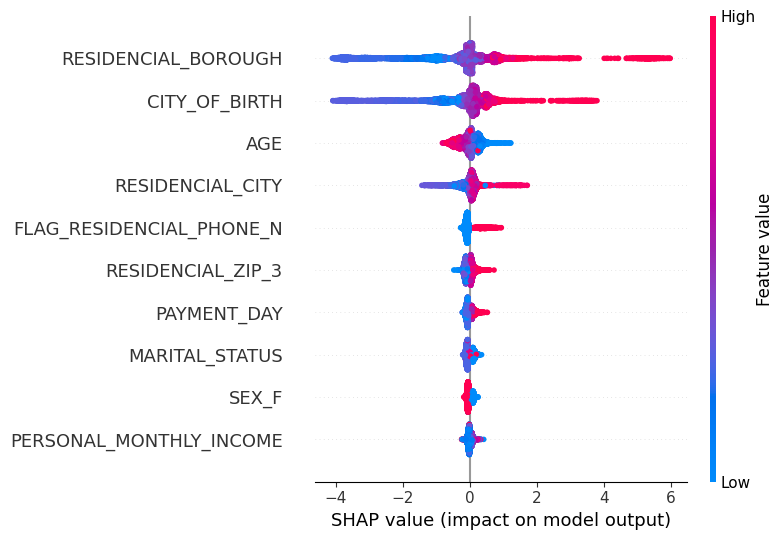

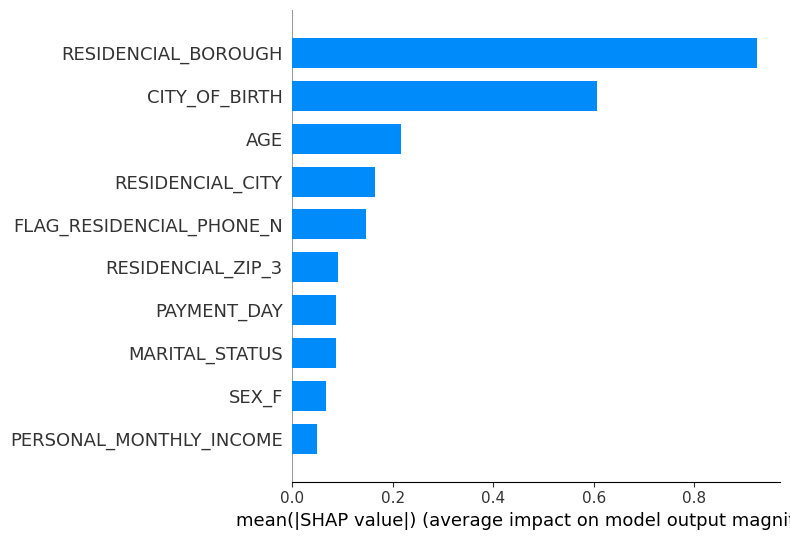

In [ ]:
explain_model_with_shap(
    model=xgb_model,
    X_train=X_train_final,
    X_test=X_val_final,
    feature_names=X_train_final.columns
)

# Bias and Fairness check

In [ ]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_fairness(y_true, y_pred, X_test, config):
    fairness_cfg = config.get("fairness", {})
    if not fairness_cfg.get("enabled", False):
        print("⚙️ Fairness evaluation disabled.")
        return

    sensitive_features_list = fairness_cfg.get("sensitive_features", [])
    print("\n⚖️ Bias & Fairness Metrics:")
    print("-" * 50)

    for feat in sensitive_features_list:
        if feat not in X_test.columns:
            print(f"\n⚠️ Skipping '{feat}' (not in data)")
            continue

        print(f"\n📊 Fairness metrics for sensitive feature: '{feat}'")
        sf = X_test[feat]

        # MetricFrame: computes metrics per group
        frame = MetricFrame(
            metrics={
                'accuracy': accuracy_score,
                'precision': precision_score,
                'recall': recall_score
            },
            y_true=y_true,
            y_pred=y_pred,
            sensitive_features=sf
        )
        print("Per-group metrics:\n", frame.by_group)

        # Group fairness disparities
        dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sf)
        eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sf)

        print(f"Demographic Parity Difference : {dpd:.4f}")
        print(f"Equalized Odds Difference     : {eod:.4f}")


In [ ]:
y_pred = xgb_model.predict(X_val_final)

evaluate_fairness(
    y_true=y_val,
    y_pred=y_pred,
    X_test=X_val_final,
    config=config_pakdd
)


⚖️ Bias & Fairness Metrics:
--------------------------------------------------

⚠️ Skipping 'SEX' (not in data)

📊 Fairness metrics for sensitive feature: 'STATE_OF_BIRTH'
Per-group metrics:
                 accuracy  precision    recall
STATE_OF_BIRTH                               
-2.835218       0.762821   0.142857  0.031250
-1.606934       0.700521   0.370370  0.198020
-1.562260       0.746098   0.336207  0.189320
-1.109722       0.729299   0.250000  0.115942
-1.056668       0.687747   0.368932  0.180952
-0.906980       0.666667   0.366667  0.154930
-0.720263       0.812500   0.750000  0.375000
-0.383500       0.666667   0.666667  0.666667
-0.090260       0.667910   0.340426  0.216216
 0.144138       0.669231   0.428571  0.146341
 0.145352       0.686275   0.250000  0.166667
 0.148363       0.681633   0.366667  0.202206
 0.304952       0.637681   0.227273  0.131579
 0.321268       0.717714   0.394958  0.211712
 0.454238       0.684693   0.347826  0.189831
 0.485825       0.866667 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Per-group metrics:
            accuracy  precision    recall
AGE                                     
-1.697602  0.504274   0.365854  0.319149
-1.630274  0.637097   0.451613  0.333333
-1.562946  0.565217   0.400000  0.222222
-1.495618  0.587719   0.407407  0.261905
-1.428290  0.648438   0.541667  0.276596
...             ...        ...       ...
 2.207423  0.828571   0.800000  0.444444
 2.274751  0.875000   0.000000  0.000000
 2.342079  0.720000   1.000000  0.125000
 2.409407  0.695652   0.000000  0.000000
 2.476735  0.677966   0.588235  0.243902

[63 rows x 3 columns]
Demographic Parity Difference : 0.3504
Equalized Odds Difference     : 0.4444

📊 Fairness metrics for sensitive feature: 'RESIDENCIAL_BOROUGH'


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Per-group metrics:
                      accuracy  precision    recall
RESIDENCIAL_BOROUGH                               
-3.339158            0.847458       0.00  0.000000
-2.846459            0.818182       0.00  0.000000
-2.747531            0.850000       0.00  0.000000
-2.733069            0.920000       0.00  0.000000
-2.522816            0.750000       0.00  0.000000
...                       ...        ...       ...
 2.622541            0.500000       0.50  0.500000
 2.639647            0.555556       0.50  1.000000
 3.315692            0.285714       0.20  0.500000
 4.003706            0.714286       0.75  0.900000
 4.238000            0.500000       0.50  0.333333

[301 rows x 3 columns]
Demographic Parity Difference : 1.0000
Equalized Odds Difference     : 1.0000


# Mitigating bias and optimizing for sensitive features

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer

def mitigate_bias_with_threshold_optimizer(model, X_train, y_train, X_val, sensitive_features_train, sensitive_features_val, config):
    mitigation_cfg = config.get("fairness", {}).get("mitigation", {})
    if not mitigation_cfg.get("enabled", False):
        print("⚙️ Bias mitigation disabled.")
        return model

    method = mitigation_cfg.get("method", "threshold_optimizer")
    constraints = mitigation_cfg.get("constraints", "demographic_parity")

    if method != "threshold_optimizer":
        print(f"⚠️ Method '{method}' not supported in this function.")
        return model

    print(f"\n⚖️ Applying ThresholdOptimizer for fairness constraint: '{constraints}'")

    # ThresholdOptimizer needs probabilities
    model_prob = model

    # Must call predict_proba inside ThresholdOptimizer
    postproc = ThresholdOptimizer(
        estimator=model_prob,
        constraints=constraints,
        prefit=True
    )

    # Fit post-processor on validation set
    postproc.fit(
        X_val,
        y_val,
        sensitive_features=sensitive_features_val
    )

    print("✅ Bias mitigation complete. Use 'predict' method of returned object for predictions.")
    return postproc


In [ ]:
sf_train = X_train_final["AGE"]      # or whichever sensitive feature to optimize for
sf_val = X_val_final["AGE"]

# Apply mitigation
fair_model = mitigate_bias_with_threshold_optimizer(
    xgb_model,
    X_train_final, y_train,
    X_val_final, sf_train, sf_val,
    config_pakdd
)

# Then predict:
y_pred = fair_model.predict(X_val_final, sensitive_features=sf_val)

# Evaluate fairness again
evaluate_fairness(y_true=y_val, y_pred=y_pred, X_test=X_val_final, config=config_pakdd)


⚖️ Applying ThresholdOptimizer for fairness constraint: 'demographic_parity'
✅ Bias mitigation complete. Use 'predict' method of returned object for predictions.

⚖️ Bias & Fairness Metrics:
--------------------------------------------------

⚠️ Skipping 'SEX' (not in data)

📊 Fairness metrics for sensitive feature: 'STATE_OF_BIRTH'
Per-group metrics:
                 accuracy  precision    recall
STATE_OF_BIRTH                               
-2.835218       0.794872   0.000000  0.000000
-1.606934       0.744792   1.000000  0.029703
-1.562260       0.787721   0.666667  0.019417
-1.109722       0.783439   1.000000  0.014493
-1.056668       0.731225   0.800000  0.038095
-0.906980       0.713080   1.000000  0.042254
-0.720263       0.750000   0.000000  0.000000
-0.383500       0.500000   0.000000  0.000000
-0.090260       0.720149   0.000000  0.000000
 0.144138       0.676923   0.000000  0.000000
 0.145352       0.764706   0.000000  0.000000
 0.148363       0.722449   0.500000  0.014706
